In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from imutils import paths
import numpy as np

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
class CustomData(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        image = io.imread(img_name)
        label = self.labels.iloc[idx, 1:]
        label = np.array([label])
        label = label.astype('float').reshape(-1,2)
        sample = {'image' : image/255, 'labels': label}
        
        if self.transform :
            sample = self.transform(sample)
            
        return sample    

In [3]:
def show_frame(image, labels):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(labels[:, 0], labels[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
#show_labels(io.imread(os.path.join('data_train/frames_labeled/', img_name)),
               #labels)
plt.show()

<Figure size 432x288 with 0 Axes>

0 (874, 1164, 3) (1, 2)


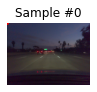

1 (874, 1164, 3) (1, 2)


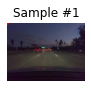

2 (874, 1164, 3) (1, 2)


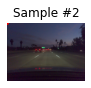

3 (874, 1164, 3) (1, 2)


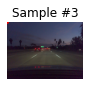

In [4]:
calib_dataset = CustomData(csv_file = 'labels.csv' ,root_dir = 'data_train/frames_labeled')
fig = plt.figure()

for i in range(len(calib_dataset)):
    sample = calib_dataset[i]

    print(i, sample['image'].shape, sample['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_frame(**sample)

    if i == 3:
        plt.show()
        break


In [5]:
class Rescale(object):
    
    def __init__(self, output_size):
        
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['labels']
        h,w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w :
                new_h, new_w = self.output_size * h/w, self.output_size
            else :
                new_h, new_w = self.output_size * w/h, self.output_size
                
        else :
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
            
        return {'image':img, 'labels':label}
    
class ToTensor(object):
    
    def __call__(self, asmple):
        
        image, labels = sample['image'], sample['labels']
        
        # swap color axis because
        # numpy image : h*w*c
        # torch image : c*h*w
        
        image = image.transpose((2,0,1))
        return {'image' : torch.from_numpy(image), 'labels': torch.from_numpy(labels)}
    


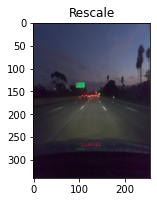

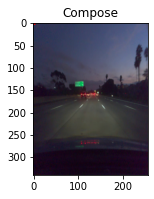

In [6]:
scale = Rescale(256)
composed = transforms.Compose([Rescale(256)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = calib_dataset[65]
for i, tsfrm in enumerate([scale, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_frame(**transformed_sample)

plt.show()

In [7]:
calib_dataset = CustomData(csv_file = 'labels.csv' ,root_dir = 'data_train/frames_labeled', transform = transforms.Compose([Rescale(256), ToTensor()]))